In [28]:
import copy
import os
import random
import glob
from collections import OrderedDict
from os.path import join as pjoin

import numpy as np
from numpy.random import exponential
from psychopy import core, visual, event

from mvpa2.misc.data_generators import simple_hrf_dataset

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# Definitions copied from my scripts

In [3]:
def showinstr(instring='Weiter mit der Leertaste'):
    """
    Show instructions and wait for key press (space bar).

    Parameters
    ----------
    instring : str
        String you want to be presented as instructions.

    Returns
    -------
    None
    """

    # create and draw window, flip screen.
    win = visual.Window(color='black', units='pix', fullscr=True)  # size=(1680, 1050)
    text = visual.TextStim(win, text=instring, color='white', height=20)
    text.draw()
    win.flip()

    # await keyboard input and close screen.
    keys = event.waitKeys(keyList=['space', 'escape'])
    if 'escape' in keys:
        win.close()
    else:
        print 'End of instructions'
        win.close()


def checkconsec(integerlist):
    """
    Helper function.
    Check whether a list of integers contains consecutive numbers. Returns True or False.
    """
    # make an ordered copy of original input list
    ordered = [i for i in integerlist]
    ordered.sort()
    # check for consecutive list elements
    consec = False
    for element in ordered[1:]:
        if element == ordered[ordered.index(element) - 1] + 1:
            consec = True
    return consec


def checkfirstlast(indiceslist,
                   targetlist):
    """
    Check if list of indices contains index for first or last element of a target list
    (i.e. 0 or len(elementlist)-1 )
    """
    # check constraint
    firstlast = False
    lastidx = len(targetlist) - 1
    if 0 in indiceslist or lastidx in indiceslist:
        firstlast = True
    return firstlast


def assertplus2(list1, list2):
    """
    Assert if list1 has at least two more elements than list2
    """
    if len(list1) < len(list2) + 2:
        raise IOError('Too many catch trials for stimulus sequence, given constraint checkfirstlast.\n'
                      'length of stimulus list : %s\n'
                      'number of desired catch trials : %s'
                      % (str(len(list1)), str(len(list2))))
    return None


def add_empty_responses(stimsequence):
    """
    Add empty dummy information for the to-be-captured responses to each stimulus dict in sequence. These are:
    Rt, accuracy, keys, trial_num, and ran. This will allow all trials with their information to be written in the
    logg-file even if they haven't run yet.
    """
    for trial_num, stimdict in enumerate(stimsequence):
        stimdict['global_onset_time'] = None
        stimdict['RT'] = None
        stimdict['accuracy'] = None
        stimdict['keys'] = None
        stimdict['trial_num'] = trial_num
        stimdict['ran'] = False
    return stimsequence


def add_catches(stimlist,
                num_catches=10,
                shuffle_inlist=True):
    """
    Add catch trials for a 1-back taks to a given stimulus sequence by repeating randomly chosen trials.
    Catch trials are not allowed To occur in first or last position of the sequence, nor can two catch trials follow
    one another. Also adds the "trial_type" key to each stimulus dict with values "normal" or "catch".
    """

    # assert that we didn't specify too many catch trials given our constraints
    assertplus2(stimlist, range(num_catches))
    # make copy of original list
    # shuffle if desired
    if shuffle_inlist:
        random.shuffle(stimlist)
    # add key-value indicating if this is a catch or normal trial
    for stim in stimlist:
        stim['trial_type'] = 'normal'

    # make list of random, non-consecutive positions for catch trials
    # with constraint that first and last trials mustn't be catch trials
    consec_bool, firstlast_bool = True, True
    catchpositions = None
    while consec_bool or firstlast_bool:
        catchpositions = random.sample(range(len(stimlist)), num_catches)
        consec_bool, firstlast_bool = checkconsec(catchpositions), checkfirstlast(catchpositions, stimlist)

    # choose items in new_stimlist (i.e. percept_dict) that should be followed by catch trials
    catchstims = [stimlist[pos] for pos in catchpositions]

    # insert catchstims into list at appropriate index
    # and mark them with 'catch'
    for catchstim in catchstims:
        stimlist.insert(stimlist.index(catchstim) + 1, catchstim)
        stimlist[stimlist.index(catchstim) + 1]['trial_type'] = 'catch'

    # make new list with copy of each original dict, else multiple entries will point to same object in memory
    stimlist_copy = [copy.copy(stimdict) for stimdict in stimlist]

    # flip trial_type of the stim right before catch trial back to 'normal'
    for idx, stim in enumerate(stimlist_copy[:-1]):
        if stimlist_copy[idx + 1]['trial_type'] == 'catch':
            stim['trial_type'] = 'normal'

    return stimlist_copy


def sample_itis_shiftruncexpon(miniti=800.,
                               maxiti=1500.,
                               aviti=1000.,
                               ntrials=141):
    """
    Sample ITIs from truncated exponential distribution which is shifted by a minimum value.
    """
    distmax = maxiti + 1
    shifted = None
    while distmax > maxiti:
        lamb = aviti - miniti
        unshifted = exponential(scale=lamb, size=ntrials)
        shifted = unshifted + miniti
        distmax = np.max(shifted)
    return shifted


def add_itis(stim_sequence,
             min_iti,
             max_iti,
             av_iti,
             jitter='shiftruncexpon'):
    """
    Add jittered inter trial intervals to a stimulus sequence.
    """
    if not jitter == 'shiftruncexpon':
        raise IOError('only the jitter type shifted truncated exponential is supported for now')
    itis = sample_itis_shiftruncexpon(miniti=min_iti, maxiti=max_iti, aviti=av_iti, ntrials=len(stim_sequence))
    for stim, iti in zip(stim_sequence, itis):
        stim['iti'] = iti
    return stim_sequence


def make_run_seq(stimdicts,
                 experiment_info,
                 blocksperrun=4,
                 with_catches=True,  # if False, don't add catch trials
                 ncatches=10,  # number of catch trials
                 miniti=.8,  # jitter args
                 maxiti=1.5,
                 aviti=1.):
    """
    Take stimulus dicts and create a list of lists, with each sublist representing the stimulus sequence of one block
    and the number of sublists corresponding to the number of blocks/repetitions in one functional run.

    Parameters
    ----------
    stimdicts : list
        each list entry represents one stimulus gathered with getstims_aloiselection
    experiment_info : dict
        additional experiment information gathered from the psychopy gui
    blocksperrun : int
        number of blocks in one functional run

    Returns
    -------
    run_sequences : list of lists
        Each sublists represents one block, and the sublist elements each represent a trial. The whole list contains
        all blocks of a given functinal run.
    """

    run_sequences = []
    for block in range(1, blocksperrun + 1):
        # for each block, create a seperate copy and add exp_info, empty responses, catches, jitter, and block number
        block_sequence = copy.deepcopy(stimdicts)
        block_sequence = add_expinfo(block_sequence, experiment_info)
        block_sequence = add_empty_responses(block_sequence)
        if with_catches:
            block_sequence = add_catches(block_sequence, num_catches=ncatches)
        block_sequence = add_itis(block_sequence, jitter='shiftruncexpon',
                                  min_iti=miniti, max_iti=maxiti, av_iti=aviti)
        for trial in block_sequence:
            trial['block'] = block
        run_sequences.append(block_sequence)

    return run_sequences



def present_run(run_sequence,
                output_csv,
                response_key='space',
                escape_key='escape',
                trigger_key='t',
                stimsize=15,
                fixdur=.500,
                stimdur=1.,
                skip_volumes=4,
                monitorname='skyra_projector'):
    """

    """
    # TODO: docstring
    # TODO: get monitor specifications from scanner (resolution, width, viewing distance, etc.)
    # TODO: use countdown timing (more precise)
    # TODO: transform presentation times into multiples of framerate, depends on monitor (but probably 60 Hz).

    # Initiate  windows, stimuli, and alike
    mon, window_ = pick_monitor(monitorname)
    event.Mouse(visible=False, win=window_)
    fixation = visual.ShapeStim(window_, size=1, lineWidth=5, closeShape=False, lineColor="white",
                                vertices=((0, -0.5), (0, 0.5), (0, 0), (-0.5, 0), (0.5, 0)))
    blank = visual.ShapeStim(window_, size=0, lineWidth=0, lineColor='black')
    stim = visual.ImageStim(window_, size=stimsize)
    escape_bool = False

    # clocks
    fix_rt = core.Clock()
    stim_rt = core.Clock()
    blank_rt = core.Clock()
    global_onset_time = core.Clock()
    firsttrig_time = core.Clock()
    skipvol_time = core.Clock()

    """
    Scanner warm up
    """

    # Wait for first scanner pulse
    firsttrig_instr = visual.TextStim(window_, text='waiting for first scanner pulse', color='white', height=2)
    firsttrig_instr.draw()
    window_.flip()
    firsttrig = event.waitKeys(keyList=[trigger_key], timeStamped=firsttrig_time)

    # do nothing during first few scans, which will be discarded before analysis
    global_onset_time.reset()
    skipvol_instr = visual.TextStim(window_, text='dummy scans', color='white', height=2)
    skipvol_instr.draw()
    window_.flip()
    for i in range(skip_volumes-1):
        dummy_keys = event.waitKeys(keyList=[trigger_key], timeStamped=skipvol_time)

    """
    Start task
    """

    # block loop
    for stim_sequence in run_sequence:

        if escape_bool:
            break

        # trial loop
        for trial in stim_sequence:

            if escape_bool:
                break

            # wait for keyboard input, time stamp with clock stim_rt
            responses = event.getKeys(keyList=[response_key, escape_key], timeStamped=stim_rt)

            # show fixation
            fix_rt.reset()
            while fix_rt.getTime() < fixdur:
                fixation.draw()
                window_.flip()

            # show stimulus
            stim.setImage(trial['file_path'])
            trial['global_onset_time'] = global_onset_time.getTime()
            stim_rt.reset()
            while stim_rt.getTime() < stimdur:
                stim.draw()
                window_.flip()

            # response evaluation
            trial['responses'] = responses
            if responses:
                trial['RT'] = responses[0][1]
                if trial['trial_type'] == 'normal':
                    trial['accuracy'] = 0
                elif trial['trial_type'] == 'catch':
                    trial['accuracy'] = 1
            else:
                if trial['trial_type'] == 'normal':
                    trial['accuracy'] = 1
                elif trial['trial_type'] == 'catch':
                    trial['accuracy'] = 0

            # show jittered blank
            blank_rt.reset()
            while blank_rt.getTime() < trial['iti']:
                blank.draw()
                window_.flip()

            # exit loop if escape key was pressed
            if responses and escape_key in responses[0]:
                escape_bool = True

            # tag this trial as presented
            trial['ran'] = True

    # add additional global info to trial dicts
    for blockseq in run_sequence:
        for trial in blockseq:
            trial['firsttrig_time'] = firsttrig[0][1]

    # write csv with output after trial loop has ended
    list_of_dictlists_2csv(run_sequence, output_csv)

    # end presentation
    window_.close()
    core.quit()

    return None


def run_first_session(stimbasedir,
                      outcsvdir,
                      nruns=4,
                      blocksprun=4,
                      testing=False,
                      mon_name='skyra_projector'):
    # create output directory
    if not os.path.exists(outcsvdir):
        os.makedirs(outcsvdir)

    # get stim sequence
    perc_dir = pjoin(stimbasedir, 'percepts')
    prep_dir = pjoin(stimbasedir, 'preprocessed')
    percept_dicts, intact_dicts = getstims_aloiselection(percepts_dir=perc_dir, preprocessed_dir=prep_dir)

    # draw gui to get exp_info
    if testing:
        exp_info = OrderedDict({'Alter': ' 1', 'Geschlecht': 'weiblich', 'Rechtshaendig': True, 'Sitzung': '1',
                                'SubjectID': '1', 'date': u'2018_Nov_06_1408', 'exp_name': 'RI_RSA'})
    else:
        exp_info = draw_gui(exp_name='RI_RSA')

    # TODO: instruction windows

    for run in range(1, nruns + 1):
        # make sequence for one run
        run_seq = make_run_seq(percept_dicts, exp_info, blocksperrun=blocksprun)
        # create csv file name (full path)
        csv_fname = pjoin(outcsvdir,
                          'sub%s_session%s_run%i_fmri.csv' % (exp_info['SubjectID'], exp_info['Sitzung'], run))
        # present one functional run
        present_run(run_seq, output_csv=csv_fname, monitorname=mon_name)

    return None

In [4]:
import csv
import glob
import os
import random
import subprocess
from collections import OrderedDict


def draw_gui(exp_name='RI_RSA',
             fields=(('SubjectID', ''), ('Gechlecht', ('maennlich', 'weiblich')),
                     ('Alter', ' '), ('Rechtshaendig', True), ('Sitzung', (1, 2)))):
    """
    Get session info from subject via a GUI.

    Parameters
    ----------
    exp_name : str
        Name of the experiment, will be stored in exp_info
    fields : tuple
        Questions presented in the gui. Tuple pairs correspond to key/value scheme of psychopy's gui dict.

    Returns
    -------
    exp_info : dict
        containing subject ID, gender, age, etc.
    """
    # initiate dict with information collected from GUI input
    exp_info = dict(fields)
    # draw gui
    dlg = gui.DlgFromDict(dictionary=exp_info, title=exp_name)
    # quit gui if user clicks 'cancel'
    if not dlg.OK:
        core.quit()
    # add additional info to exp_info which doesn't come from GUI input
    exp_info = OrderedDict(exp_info)
    exp_info['exp_name'] = exp_name
    exp_info['date'] = data.getDateStr()

    return exp_info


def id2name_dict():
    id2name = {
        '9': 'Schuh',
        '40': 'Gluehbirne',
        '89': 'Tube',
        '90': 'Ente',
        '125': 'Tasse',
        '161': 'Kanne',
        '263': 'Rahmen',
        '281': 'Knoblauch',
        '405': 'Locher',
        '408': 'Wuerfel',
        '461': 'Toilettenpapier',
        '466': 'Stift',
        '615': 'Dose',
        '642': 'Tacker',
        '910': 'Spruehflasche',
        '979': 'Hut'
    }
    return id2name


def getstims_aloiselection(percepts_dir='./Stimuli/percepts',
                           preprocessed_dir='./Stimuli/preprocessed',
                           id2namedict=id2name_dict()):
    """
    Create list of dicts containing information about all experimental stimuli, like their
    vision type ('ri_percept' vs. 'intact'), rotation, object_id and file_path.

    Parameters
    ----------
    percepts_dir : str
        Path to directory with RI percept images (should be .png).
    preprocessed_dir : str
        Path to directory with intact object images (which were also preprocessed in my case).
    id2namedict : dict
        for assigning object_names based on object_ids (because only object_ids are in the file names).

    Returns
    -------
    percept_dicts : list of dicts
        Each dict stands for one RI percept stimulus, containing key-value pairs for vision, rotation, object_id,
        object_name, and file path.
    intact_dicts : list of dicts
        Same as percept_dicts but for intact object stimuli.
    """
    #  check if input directory exists
    for directory in [percepts_dir, preprocessed_dir]:
        if not os.path.exists(directory):
            raise IOError('Could not find stimulus input directory : %s' % directory)

    # get files in directory
    percept_fpaths = glob.glob(percepts_dir + '/*.png')
    intact_fpaths = glob.glob(preprocessed_dir + '/*.png')

    # collect info from percept file names
    percept_dicts = []
    for percept_fpath in percept_fpaths:
        # vision1 and vision2 are not actually used for the dict
        object_id, rotation, vision1, vision2 = tuple(percept_fpath.split('/')[-1].split('.')[0].split('_'))
        percept_dict = OrderedDict({'file_path': percept_fpath,
                                    'object_id': object_id,
                                    'rotation': int(rotation.replace('r', '')),
                                    'vision': 'ri_percept'})
        percept_dicts.append(percept_dict)

    # collect info from intact (prepped) object file names
    intact_dicts = []
    for intact_fpath in intact_fpaths:
        object_id, rotation, vision = tuple(intact_fpath.split('/')[-1].split('.')[0].split('_'))
        intact_dict = OrderedDict({'file_path': intact_fpath,
                                   'object_id': object_id,
                                   'rotation': int(rotation.replace('r', '')),
                                   'vision': 'intact'})
        intact_dicts.append(intact_dict)

    # add object name
    for dictlist in [percept_dicts, intact_dicts]:
        for stimdict in dictlist:
            stimdict['object_name'] = id2namedict[stimdict['object_id']]

    return percept_dicts, intact_dicts


def add_trainingtest(percept_dicts,
                     intact_dicts):
    """
    Randomly choose half of the object stimuli and assign them to a 'training' or 'test' set.
    """

    objects = np.unique([stimdict['object_name'] for stimdict in percept_dicts])
    random.shuffle(objects)

    training_obs = objects[:len(objects) / 2]
    novel_obs = objects[len(objects) / 2:]

    for dictlist in [percept_dicts, intact_dicts]:
        for stimdict in dictlist:
            if stimdict['object_name'] in training_obs:
                stimdict['set'] = 'training'
            elif stimdict['object_name'] in novel_obs:
                stimdict['set'] = 'novel'
            else:
                raise KeyError('could not evaluate wether training or test object. stimulus is: %s'
                               % stimdict['file_path'])

    return percept_dicts, intact_dicts


def select_train(percept_dicts):
    selected = [pdict for pdict in percept_dicts if pdict['set'] == 'training']
    return selected


def add_expinfo(stimsequence, exp_info):
    """
    Add key-value pairs in exp_info to list of stimdicts defined in stim_sequence so it will be
    captured in our logg files.
    """
    for stimdict in stimsequence:
        stimdict.update(exp_info)
    return stimsequence


def dictlist2csv(dictlist, csv_fname):
    """
    Write a list of dictionaries to a csv file. In our case, this function is used to write the logg-file after all
    trials have run or experimenter exits via escape.
    This will only work if all dicts have the same keys.
    """
    # assert if all keys are the same
    for stimdict in dictlist[1:]:
        if not set(stimdict.keys()) == set(dictlist[0].keys()):
            raise IOError('not all dicts in dictlist have the same keys.')
    # write csv
    header_keys = dictlist[0].keys()
    with open(csv_fname, 'wb') as f:
        dict_writer = csv.DictWriter(f, header_keys)
        dict_writer.writeheader()
        dict_writer.writerows(dictlist)
    return None


def list_of_dictlists_2csv(dictlistslist, csv_fname):
    """
    take a list of lists, each containing dicts with equivalent keys and write their contents into a csv file.
    """
    header_keys = dictlistslist[0][0].keys()
    with open(csv_fname, 'wb') as f:
        dict_writer = csv.DictWriter(f, header_keys)
        dict_writer.writeheader()
        for dictlist in dictlistslist:
            dict_writer.writerows(dictlist)
    return None


def pick_monitor(mon_name='samsung_office'):
    """
    Create a psychopy monitor and window instance depending on where you want to display the experiment.
    """
    allowed = ['samsung_office', 'samsung_behavlab', 'soundproof_lab']
    if mon_name not in allowed:
        raise IOError('Could not find settings for mon : %s' % mon_name)
    mon, win = None, None
    if mon_name == 'samsung_office':
        res = (1920, 1080)
        mon = monitors.Monitor(mon_name, width=60., distance=60.)
        mon.setSizePix(res)
        win = visual.Window(monitor=mon, size=res, color='black', units='deg', screen=0, fullscr=True)
    elif mon_name == 'samsung_behavlab':
        res = (1920, 1080)
        mon = monitors.Monitor(mon_name, width=52.2, distance=60.)
        mon.setSizePix(res)
        win = visual.Window(monitor=mon, size=res, color='black', units='deg', screen=0, fullscr=True)
    elif mon_name == 'soundproof_lab':
        res = (1920, 1080)
        mon = monitors.Monitor(mon_name, width=53., distance=80.)  # cheat distance: 60, actual distance: 81.3
        mon.setSizePix(res)
        win = visual.Window(monitor=mon, size=res, color='black', units='deg', screen=0, fullscr=True)
    # mon.save()
    # TODO: 'skyra_projector'
    return mon, win


def movemouse_xdotool(psychopy_mon,
                      xoffset=0,
                      yoffset=230):
    """
    Execute shell command (xdotool) to reset mouse position when psychopy's pyglet module throws an error (as is
    the case in our soundproof_lab).

    Note that x and y coordinates start at zero in the upper left corner,
    so xoffset moves to the right, and yoffset moves down.
    """
    xres, yres = psychopy_mon.getSizePix()
    subprocess.Popen(["xdotool", "mousemove",
                      str((float(xres)/2) + xoffset),
                      str((float(yres)/2) + yoffset)])
    return None


def avoidcorner_xdotool(psychopy_mon,
                        xoffset=0,
                        yoffset=200,
                        quiesce=100):
    """
    Avoid annoying gnome feature (hot corners) that shows a workspace overview when the mouse hits the upper-left corner
    by simply re-positioning the mouse to a neutral position whenever this happens.
    """
    xres, yres = psychopy_mon.getSizePix()
    subprocess.Popen(['xdotool', 'behave_screen_edge', '--quiesce', str(quiesce), 'top-left', 'mousemove',
                      str((float(xres)/2) + xoffset),
                      str((float(yres)/2) + yoffset)])
    return None


def show_instr(window_instance,
               message="Lorem ipsum dolor sit amet.",
               textsize=.8,
               unit='deg',
               continue_key='space'):
    textstim = visual.TextStim(window_instance, height=textsize, units=unit, wrapWidth=40)
    textstim.setText(message)
    textstim.draw()
    window_instance.flip()
    event.waitKeys(keyList=[continue_key])
    return None


In [5]:
exp_info = OrderedDict({'Alter': ' 1', 'Geschlecht': 'weiblich', 'Rechtshaendig': True, 'Sitzung': '1',
                                'SubjectID': '1', 'date': u'2018_Nov_06_1408', 'exp_name': 'RI_RSA'})

In [6]:
stimbasedir = '/Users/Oliver/ri_hmax/experiments/RI_objects_RSA/Stimuli/'

In [7]:
perc_dir = pjoin(stimbasedir, 'percepts')
prep_dir = pjoin(stimbasedir, 'preprocessed')
percept_dicts, intact_dicts = getstims_aloiselection(percepts_dir=perc_dir, preprocessed_dir=prep_dir)

# Generate run

Which comprises both intact object and ri percept stimuli

In [8]:
def simulate_run_bothtypes(percept_dicts, intact_dicts, exp_info,
                           reps_per_run=1,
                           catches=20,
                           assign_training=True,
                           mute_irrelevant_keys=True):
    """
    Design a block containing one full repetition of all stimuli, i.e. intact as well as ri percept images,
    in random order, with catch trials, and everything.
    
    Randomly assign half of both intact and ri stimuli the values 'trained' or 'untrained'
    under the key 'training'.
    
    # TODO: complete docstring
    """
    
    # get sequence for intact and ri seperately (without catch trials),
    # by using one of my functions
    percept_sequence = make_run_seq(percept_dicts, exp_info, blocksperrun=reps_per_run, with_catches=False)
    percept_sequence = percept_sequence[0]
    intact_sequence = make_run_seq(intact_dicts, exp_info, blocksperrun=1, with_catches=False)
    intact_sequence = intact_sequence[0]
    
    # assign 'trained' and 'untrained' markers to half of each intact and ri stimuli
    if assign_training:
        for perc_stim, int_stim in zip(percept_sequence[:len(percept_sequence)/2],
                                       intact_sequence[:len(intact_sequence)/2]):
            perc_stim['training'] = 'trained'
            int_stim['training'] = 'trained'
        for perc_stim, int_stim in zip(percept_sequence[len(percept_sequence)/2:],
                                       intact_sequence[len(intact_sequence)/2:]):
            perc_stim['training'] = 'untrained'
            int_stim['training'] = 'untrained'
        
    # merge
    # TODO: here is where I can have constraints on my sequence
    # (e.g. not more than 5 stims per condition in a row, or similar)
    full_seq = intact_sequence + percept_sequence

    # add catches and shuffle
    full_seq = add_catches(full_seq, num_catches=catches, shuffle_inlist=True)
    
    # set a bunch of parameters to None, so as not to confuse this with a real trial sequence!
    # TODO: alternatively, delete them
    if mute_irrelevant_keys:
        nonekeys = ['rotation', 'file_path', 'object_id', 'object_name']
        for stim in full_seq:
            for nonekey in nonekeys:
                stim[nonekey] = None
    
    return full_seq

In [9]:
stim_sequence = simulate_run_bothtypes(percept_dicts, intact_dicts, exp_info)

In [10]:
len(stim_sequence)

276

# Extract design matrix

In [11]:
def add_ons_dur_inten(stimsequence,
                      stimdur=.8,
                      fixdur=.2,
                      intensity=1):
    """
    Add onset, duration, and intensity to stimulus sequence.
    """

    # onsets
    for idx in range(len(stimsequence)):
        if idx == 0:
            # all onsets are relative to first trial (with onset 0) for purpose of efficiency estimation
            stimsequence[idx]['onset'] = 0
        else:
            stimsequence[idx]['onset'] = stimsequence[idx-1]['onset'] + fixdur + stimdur + stimsequence[idx-1]['iti']

    # durations + intensities
    for stim in stimsequence:
        stim['duration'] = stimdur
        stim['intensity'] = intensity
        
    return stimsequence

In [12]:
stim_sequence = add_ons_dur_inten(stim_sequence)

In [215]:
def extract_onsets(stim_sequence):
    
    # initiate list of regressor dicts to save the onsets.
    regressors = [
        {'regname':'intact', 'onsets':[]},
        {'regname':'ri_percept', 'onsets':[]},
        {'regname':'trained', 'onsets':[]},
        {'regname':'untrained','onsets':[]},
        {'regname':'catch', 'onsets':[]}
    ]
    
    # set regressor values by going through the stim sequence
    for stim in stim_sequence:
        if stim['vision'] == 'intact':
            regressors[0]['onsets'].append(stim['onset'])
        elif stim['vision'] == 'ri_percept':
            regressors[1]['onsets'].append(stim['onset'])
        else:
            raise IOError('could not assess vision')
        if stim['training'] == 'trained':
            regressors[2]['onsets'].append(stim['onset'])
        elif stim['training'] == 'untrained':
            regressors[3]['onsets'].append(stim['onset'])
        else:
            raise IOError('could not assess training')
        if stim['trial_type'] == 'catch':
            regressors[4]['onsets'].append(stim['onset'])

    return regressors

In [ ]:
def extract_onsets_new(stim_sequence):
    
    # initiate list of regressor dicts to save the onsets.
    regressors = [
        {'regname':'intact_trained', 'onsets':[]},
        {'regname':'intact_untrained', 'onsets':[]},
        {'regname':'ri_percept_trained', 'onsets':[]},
        {'regname':'ri_percept_untrained', 'onsets':[]},
        {'regname':'untrained','onsets':[]},
        {'regname':'catch', 'onsets':[]}
    ]
    
    # set regressor values by going through the stim sequence
    for stim in stim_sequence:
        if stim['vision'] == 'intact':
            regressors[0]['onsets'].append(stim['onset'])
        elif stim['vision'] == 'ri_percept':
            regressors[1]['onsets'].append(stim['onset'])
        else:
            raise IOError('could not assess vision')
        if stim['training'] == 'trained':
            regressors[2]['onsets'].append(stim['onset'])
        elif stim['training'] == 'untrained':
            regressors[3]['onsets'].append(stim['onset'])
        else:
            raise IOError('could not assess training')
        if stim['trial_type'] == 'catch':
            regressors[4]['onsets'].append(stim['onset'])

    return regressors

In [218]:
onset_dicts = extract_onsets(stim_sequence)

In [222]:
def construct_design_matrix(onset_dicts):
    """
    # TODO: docstring
    """
    
    # convolve onsets with hrf to get regressors
    regressors_conv = []
    for regressor in onset_dicts:
        convolved_ds = simple_hrf_dataset(events=regressor['onsets'], tr=2, tres=1,
                                          baseline=0, signal_level=1, noise_level=0)
        convolved_reg = convolved_ds.sa['design'].value[:,0]
        # pymvpa scales effect sizes to 2. We want them to be 1
        convolved_reg_scaled = convolved_reg / 2
        regressors_conv.append(convolved_reg_scaled)
        
    # padd regressors to same length
    # determine maximum length
    maxlen = 0
    for regressor in regressors_conv:
        if len(regressor) >= maxlen:
            maxlen = len(regressor)

    # pad shorter regressors accordingly
    for regressor in regressors_conv:
        if len(regressor) < maxlen:
            regressors_conv[regressors_conv.index(regressor)] = np.pad(regressor, (0, maxlen-len(regressor)), 'edge')
            
    # construct intercept vector and add to first position
    intercept = np.ones(len(regressors_conv[0]))
    design_matrix = np.vstack((intercept, regressors_conv))

    # get dimensions right (rows should be samples, columns should be regressors)
    design_matrix = design_matrix.transpose()

    return design_matrix

In [223]:
design_matrix = construct_design_matrix(onset_dicts)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [226]:
np.shape(design_matrix)

(282, 6)

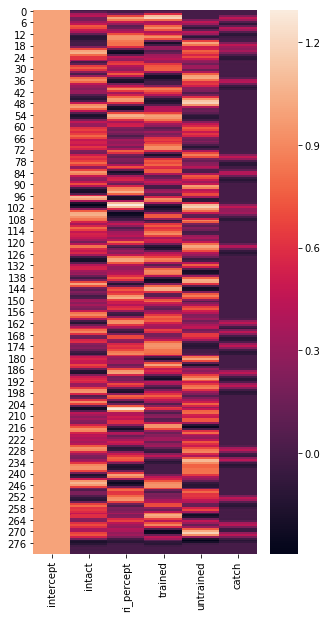

In [230]:
fig, ax = plt.subplots(figsize=(5,10))
sns.heatmap(design_matrix,
            xticklabels= ['intercept'] + [i['regname'] for i in onset_dicts])

# TODO:

- re-do design matrix / regressors so I can look at interactions, i.e. regressors 'intact_trained', 'intact_untrained', etc.
- calculate variance inflation error

# Calculate efficiency

Notes on matrix algebra in numpy

- design_matrix.T is equivalent to np.transpose(design_matrix)
- use np.dot() for multiplication of TWO matrices.
- for multiplication of more than two matrices, use dot several times
- or use matrix.dot() method, e.g. matrix1.dot(matrix2).dot(matrix3)
- use np.linalg.inv() for matrix inverse

In [283]:
# construct constrast matrix

# intact > ri_percept
cvec1 = np.array([0,1,-1,0,0,0])
# intact < ri_percept
cvec2 = np.array([0,-1,1,0,0,0])
# trained > untrained
cvec3 = np.array([0,0,0,1,-1,0])
# trained < untrained
cvec4 = np.array([0,0,0,-1,1,0])

# stack arrays into contrast matrix
cmat = np.vstack((cvec1, cvec2, cvec3, cvec4))

In [284]:
cmat

array([[ 0,  1, -1,  0,  0,  0],
       [ 0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0],
       [ 0,  0,  0, -1,  1,  0]])

In [285]:
def efficiency(design_matrix, contrast_matrix):
    """
    TODO: make this flexible for single contrast vectors as well
    """
    eff = 1 / np.trace(
        contrast_matrix.dot(np.linalg.inv(design_matrix.T.dot(design_matrix))).dot(contrast_matrix.T))
    return eff

In [286]:
efficiency(design_matrix, cmat)

7.219414709436306